## Global Configuration

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import os
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

from deel.puncc.api.prediction import BasePredictor
from deel.puncc.classification import APS, RAPS

# Choose CPU or GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # "0"

# Load data
with open("data/imagenet_dict.txt") as f:
    data = f.read()
    imagenet_catalogue = eval(data)

# Load ResNet-50 with weights
model = tf.keras.applications.ResNet50(weights="imagenet")
model.compile(
    loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"]
)

# Wrap ResNet-50 in a BasePredictor and indicate that the model is already trained
resnet50_predictor = BasePredictor(model, is_trained=True)


# Source: https://docs.fast.ai/tutorial.imagenette.html
directory_imagenette_labels_dict = {
    "n01440764": "tench",
    "n02102040": "English springer",
    "n02979186": "cassette player",
    "n03000684": "chain saw",
    "n03028079": "church",
    "n03394916": "French horn",
    "n03417042": "garbage truck",
    "n03425413": "gas pump",
    "n03445777": "golf ball",
    "n03888257": "parachute",
}

# Source: https://walkwithfastai.com/DBlock_Summary
directory_dogbreed_dict = {
    "n02086240": "Shih-Tzu",
    "n02087394": "Rhodesian ridgeback",
    "n02088364": "Beagle",
    "n02089973": "English foxhound",
    "n02093754": "Australian terrier",
    "n02096294": "Border terrier",
    "n02099601": "Golden retriever",
    "n02105641": "Old English sheepdog",
    "n02111889": "Samoyed",
    "n02115641": "Dingo",
}


## Data loading and preparation: Imagenette 

In [ ]:
# Imagenette is downloadable from https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
# Extract in data folder


# create a new generator
imagegen = ImageDataGenerator()

# Number of images to load per iteration
batch_size = 2048

# Takes the path to imagenette to generates train and validation batches
imagenette_train = imagegen.flow_from_directory(
    "data/imagenette/train",
    class_mode="binary",
    shuffle=True,
    seed=0,
    batch_size=batch_size,
    target_size=(224, 224),
)
imagenette_val = imagegen.flow_from_directory(
    "data/imagenette/val",
    class_mode="binary",
    shuffle=True,
    seed=0,
    batch_size=batch_size,
    target_size=(224, 224),
)

# Dictionary imagenette label => file name
imagenette_label_file_catalogue = {
    v: k for k, v in imagenette_val.class_indices.items()
}

# Dictionary imagenette label => name
imagenette_catalogue = {
    k: directory_imagenette_labels_dict[v]
    for k, v in imagenette_label_file_catalogue.items()
}

# Dictionary imagenette label => imagenet label
imagenette_imagenet_label_map = {}
for imagenette_key, imagenette_value in imagenette_catalogue.items():
    imagenet_key = [
        k for k, v in imagenet_catalogue.items() if imagenette_value in v
    ]
    imagenette_imagenet_label_map[imagenette_key] = imagenet_key[0]


# Function to translate labels encoded from Imagenette to Imagenet
def nette_to_net_labels(labels):
    return np.array([imagenette_imagenet_label_map[label] for label in labels])


## Conformal prediction on Imagenette with ResNet-50

In [ ]:
# The predictor is already trained, we will skip model fitting
# by setting argument `train` to False
imagenette_aps = APS(resnet50_predictor, train=False)
imagenette_raps = RAPS(resnet50_predictor, train=False, lambd=0.01, k_reg=6)

# fit on Imagenette
for images, labels in imagenette_train:
    X_calib = images
    y_calib = nette_to_net_labels(labels)
    # Provide only calibration set as model is already trained
    imagenette_aps.fit(X_calib=X_calib, y_calib=y_calib)
    imagenette_raps.fit(X_calib=X_calib, y_calib=y_calib)
    break

# Values of alpha to experiment with
alphas = np.arange(0.1, 1, 0.1)

# Test on imagenette
results = []
for images, labels in imagenette_val:
    X_test = images
    y_test = nette_to_net_labels(labels)

    # Build prediction sets for APS and RAPS with different values of alpha
    # and compute metrics
    for alpha in tqdm(alphas):
        # Prediction
        y_pred_aps, set_pred_aps = imagenette_aps.predict(X_test, alpha=alpha)
        y_pred_raps, set_pred_raps = imagenette_raps.predict(
            X_test, alpha=alpha
        )

        # Compute average coverage and size
        coverage_aps = classification_mean_coverage(y_test, set_pred_aps)
        coverage_raps = classification_mean_coverage(y_test, set_pred_raps)
        mean_size_aps = classification_mean_size(set_pred_aps)
        mean_size_raps = classification_mean_size(set_pred_raps)

        # Append iteration results
        results.append(["APS Imagenette", alpha, coverage_aps, mean_size_aps])
        results.append(
            ["RAPS Imagenette", alpha, coverage_raps, mean_size_raps]
        )
    break

with open("results/results_classification_imagenette.pickle", "wb") as output_file:
    pickle.dump(results, output_file)


## Data loading and preparation: Imagewoof 

In [ ]:
# Imagewoof is downloadable from https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-320.tgz
# Extract in data folder

# create a new generator
imagegen = ImageDataGenerator()

# Number of images to load per iteration
batch_size = 2048

# Takes the path to imagewoof directory to generates train and validation batches
imagewoof_train = imagegen.flow_from_directory(
    "data/imagewoof/train",
    class_mode="binary",
    shuffle=True,
    seed=0,
    batch_size=batch_size,
    target_size=(224, 224),
)
imagewoof_val = imagegen.flow_from_directory(
    "data/imagewoof/val",
    class_mode="binary",
    shuffle=True,
    seed=0,
    batch_size=batch_size,
    target_size=(224, 224),
)

# Dictionary imagewoof label => file name
imagewoof_label_file_catalogue = {
    v: k for k, v in imagewoof_val.class_indices.items()
}

# Dictionary imagewoof label => dogbreed
imagewoof_catalogue = {
    k: directory_dogbreed_dict[v]
    for k, v in imagewoof_label_file_catalogue.items()
}

# Dictionary imagewoof label => imagenet label
imagewoof_imagenet_label_map = {}
for imagewoof_key, imagewoof_value in imagewoof_catalogue.items():
    imagenet_key = [
        k for k, v in imagenet_catalogue.items() if imagewoof_value in v
    ]
    imagewoof_imagenet_label_map[imagewoof_key] = imagenet_key[0]


# Function to translate labels encoded from Imagewoof to Imagenet
def woof_to_net_labels(labels):
    return np.array([imagewoof_imagenet_label_map[label] for label in labels])


## Conformal prediction on Imagewoof with ResNet-50

In [ ]:
# The predictor is already trained, we will skip model fitting
# by setting argument `train` to False
imagewoof_aps = APS(resnet50_predictor, train=False)
imagewoof_raps = RAPS(resnet50_predictor, train=False, lambd=0.01, k_reg=6)

# Fit APS and RAPS on Imagewoof
for images, labels in imagewoof_train:
    X_calib = images
    y_calib = woof_to_net_labels(labels)
    # Provide only calibration set as model is already trained
    imagewoof_aps.fit(X_calib=X_calib, y_calib=y_calib)
    imagewoof_raps.fit(X_calib=X_calib, y_calib=y_calib)
    break

# Values of alpha to experiment with
alphas = np.arange(0.1, 1, 0.1)

# Test on imagewoof
results = []
for images, labels in tqdm(imagewoof_val):
    X_test = images
    y_test = woof_to_net_labels(labels)
    # Build prediction sets for APS and RAPS with different values of alpha
    # and compute metrics
    for alpha in alphas:
        # Prediction
        y_pred_aps, set_pred_aps = imagewoof_aps.predict(X_test, alpha=alpha)
        y_pred_raps, set_pred_raps = imagewoof_raps.predict(X_test, alpha=alpha)

        # Compute average coverage and size
        coverage_aps = classification_mean_coverage(y_test, set_pred_aps)
        coverage_raps = classification_mean_coverage(y_test, set_pred_raps)
        mean_size_aps = classification_mean_size(set_pred_aps)
        mean_size_raps = classification_mean_size(set_pred_raps)

        # Append iteration results
        results.append(["APS Imagewoof", alpha, coverage_aps, mean_size_aps])
        results.append(["RAPS Imagewoof", alpha, coverage_raps, mean_size_raps])
    break

with open("results/results_classification_imagewoof.pickle", "wb") as output_file:
    pickle.dump(results, output_file)


## Results

In [2]:
from deel.puncc.metrics import (
    classification_mean_coverage,
    classification_mean_size,
)

# Load results on Imagenette
with open("results/results_classification_imagenette.pickle", "rb") as input_file:
    imagenette_results = pickle.load(input_file)

results_df_imagenette = pd.DataFrame(
    imagenette_results, columns=["method", "alpha", "coverage", "size"]
)

# Load results on Imagewoof
with open("results/results_classification_imagewoof.pickle", "rb") as input_file:
    imagewoof_results = pickle.load(input_file)

results_df_imagewoof = pd.DataFrame(
    imagewoof_results, columns=["method", "alpha", "coverage", "size"]
)

# Validity
results_df_imagenette["ace"] = abs(
    1 - results_df_imagenette["alpha"] - results_df_imagenette["coverage"]
)
results_df_imagewoof["ace"] = abs(
    1 - results_df_imagewoof["alpha"] - results_df_imagewoof["coverage"]
)


In [3]:
# Compute average size and coverage gap
results_df_imagewoof.groupby(["method"])[["size", "ace"]].mean()


,size,ace
method,,
APS Imagewoof,40.631727,0.025499
RAPS Imagewoof,21.207737,0.025445


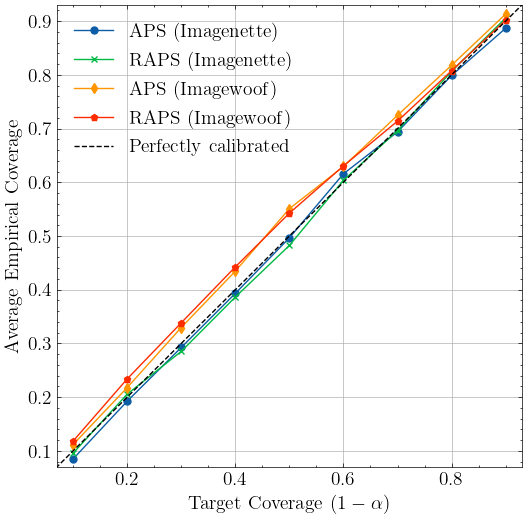

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

import scienceplots
plt.style.use(['science'])

plt.rcParams['font.size'] = 14

alphas = np.arange(.1, 1, .1)

markers_imagenette = ["-o", "-x"]

markers_imagewoof = ["-d", "-p"]

fig, ax = plt.subplots(figsize=(6,6))

labels_imagenette = ["APS (Imagenette)", "RAPS (Imagenette)"]
labels_imagewoof = ["APS (Imagewoof)", "RAPS (Imagewoof)"]


for i, method in enumerate(results_df_imagenette["method"].unique()):
    filter = results_df_imagenette["method"] == method
    ax.plot(1-results_df_imagenette[filter]["alpha"], results_df_imagenette[filter]["coverage"], markers_imagenette[i], label=labels_imagenette[i], markersize=5)

for i, method in enumerate(results_df_imagewoof["method"].unique()):
    filter = results_df_imagewoof["method"] == method
    ax.plot(1-results_df_imagewoof[filter]["alpha"], results_df_imagewoof[filter]["coverage"], markers_imagewoof[i], label=labels_imagewoof[i], markersize=5)

ax.plot(np.arange(0,1.1,.1), np.arange(0,1.1,.1), "--", c="k", label="Perfectly calibrated", markersize=5)

ax.set_xlabel(r"Target Coverage ($1-\alpha$)")
ax.set_ylabel(r"Average Empirical Coverage")

ax.set_xlim([0.07,.93])
ax.set_ylim([0.07,.93])

ax.grid(True)

plt.legend()

plt.savefig("classification_coverage.pdf")

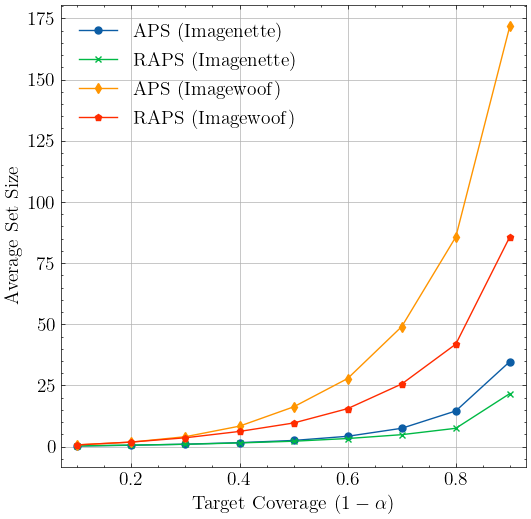

In [5]:
fig, ax = plt.subplots(figsize=(6, 6))

for i, method in enumerate(results_df_imagenette["method"].unique()):
    filter = results_df_imagenette["method"] == method
    ax.plot(
        1 - results_df_imagenette[filter]["alpha"],
        results_df_imagenette[filter]["size"],
        markers_imagenette[i],
        label=labels_imagenette[i],
        markersize=5,
    )

for i, method in enumerate(results_df_imagewoof["method"].unique()):
    filter = results_df_imagewoof["method"] == method
    ax.plot(
        1 - results_df_imagewoof[filter]["alpha"],
        results_df_imagewoof[filter]["size"],
        markers_imagewoof[i],
        label=labels_imagewoof[i],
        markersize=5,
    )

ax.set_xlabel(r"Target Coverage ($1-\alpha$)")
ax.set_ylabel(r"Average Set Size")

ax.set_xlim([0.07, 0.93])

ax.grid(True)

plt.legend()

plt.savefig("classification_size.pdf")
